**IMPORT LIBRARY**

In [1]:
import numpy as np
import string 
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
import nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
import reprlib
import csv
import vaderSentiment
import re

**IMPORT DATA TWEET**

In [2]:
df = pd.read_csv('mbkm1.csv',sep=';', skiprows=0, low_memory=True)
df.head(2)

,user,id,date,text
0,UPIfess,"1,66E+18",29/05/2023 14.45,"!upi guys mau minta saran dong, di prodi sende..."
1,symerewraith,"1,66E+18",28/05/2023 11.11,@telyufess w ikut 22nya. kp internal gadapet u...


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dions\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**DATA CLEANING**

In [4]:
def remove_tweet_special(text):
    # menghapus tab, garis baru, dan backslash
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # menghapus non ASCII (emotikon, kata-kata china, dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # Text Lower
    text = text.lower()
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
df['text'] = df['text'].apply(remove_tweet_special)

#menghapus angka
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['text'] = df['text'].apply(remove_number)

# #menghapus tanda baca
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# #menghapus whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['text'] = df['text'].apply(remove_whitespace_LT)

# #menghapus whitespace ganda menjadi satu whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['text'] = df['text'].apply(remove_whitespace_multiple)

# menghapus satu karakter
def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['text'] = df['text'].apply(remove_single_char)
def remove_moving_char(text):
    return ' ',(text.split()) 

**CASE FOLDING**

In [5]:
df['text'] = df['text'].str.lower()

In [6]:
# MENGHITUNG JUMLAH DUPLIKAT KALIMAT
df.duplicated(subset=['text']).sum()

74

In [7]:
# MENGETAHUI KALIMAT YANG DOUBLE
print(df.dropna().loc[df['text'].duplicated()])

                 user        id              date  \
170         smftundip  1,54E+18  19/06/2022 21.38   
195       ditjendikti  1,50E+18  21/02/2022 09.21   
368        UFOveteran  1,66E+18  26/05/2023 20.50   
451       yellow_3toR  1,66E+18  23/05/2023 09.07   
466    897GlobalRadio  1,66E+18  22/05/2023 18.19   
...               ...       ...               ...   
2531     urloved_sahi  1,61E+18  02/01/2023 13.23   
2532         aiuerin_  1,61E+18  02/01/2023 13.22   
2551  HanaSabrina2805  1,61E+18  02/01/2023 10.35   
2640        nihcinoya  1,61E+18  24/12/2022 16.46   
2668    pulchritudeye  1,61E+18  22/12/2022 20.14   

                                                   text  
170   forum ini mengangkat isu kuliah offline merdek...  
195   halo mahasiswa yang mengikuti program studi in...  
368   our speakers aprilda rosita fujianty pardede s...  
451                   manifesting lolos kampus mengajar  
466   dukung penguatan pendidikan vokasi kampus meng...  
...            

In [8]:
# MENGHAPUS JUMLAH DUPLIKAT KALIMAT
df.drop_duplicates(subset='text',keep=False, inplace=True)

**MENGHAPUS DI TWEET DILUAR DARI KATA KUNCI**

In [9]:
def contain_candidate (text, candidate):
    if candidate == 'mbkm' :
        if any(person in text.lower().replace(' ','') \
               for person in ['mbkm','MBKM','Mbkm']):
             return 1
        else:
            return 0

In [10]:
df['mbkm'] = df.text.apply(contain_candidate, args=('mbkm',))

In [11]:
df.drop(df[df.mbkm < 1].index, inplace=True)

In [12]:
# MENGAHAPUS VARIABEL YANG TIDAK DI INGINKAN
df.drop('mbkm', inplace=True, axis=1)

**TOKENISASI**

In [13]:
# NLTK word rokenize 
def tokenize_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens
df['tokenisasi'] = df['text'].apply(tokenize_text)
df['tokenisasi']

0       [upi, guys, mau, minta, saran, dong, di, prodi...
1       [ikut, nya, kp, internal, gadapet, uang, tp, g...
2       [saran, gua, kalo, lu, pada, mau, ikut, mbkm, ...
3       [gapapa, nder, aku, gpernah, ngmg, berapa, gaj...
4       [ugmfess, kalo, mbkm, tu, masih, dapet, uang, ...
                              ...                        
2558    [harapanku, cuma, dipermudah, lolos, program, ...
2567    [mbkm, merdeka, belajar, kampus, mengajar, pro...
2642    [fess, bukan, lebih, tepatnya, jt, harusnya, s...
2643    [fess, mbkm, apa, nder, setauku, cmn, yg, kamp...
2671    [lewat, kampus, mengajar, mahasiswa, program, ...
Name: tokenisasi, Length: 387, dtype: object

In [14]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dions\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**STOPWORDS**

In [16]:
list_stopwords = stopwords.words("indonesian")
list_stopwords.extend(['upi','xr','guis','iya','nad','yuhu','yuhuu','imo','kp','seulgi','aaaaaaaaaaaaaaaaaa', 'solo', 'ugmfess','yuhuuyyyy','yukk','yuhuu','yok', 'kakakkakak', 'Unud', 'markisa',
                       'kek', 'FESS', 'bjing','Ndes','mu','cmiiw', 'woyy', 'si','wkwkw', 'ee','ugmfess', 'Mjb', 'Widiii','yupien','takiro',
                       'wkwkkw', 'mashok','pmm','pic','sih', 'sem', 'Pen', 'Fyi', 'sakuakomodasinya', 'company','simon','hdh','hdh',
                       'COK', 'ga', 'ya','rbrb','markisa','hmm','cbc','Arghh','Hallo', 'Manifesting','yey','md', 'dal', 'lus', 'blmrt', 'windut', 'oke', 'nyil', 'someday',
                       'BBH', 'woeee', 'anjeeeeng', 'ni','kmmi','gegara','nad','waa','fuck','drimstan','siipp','sucks','ain',
                       'yaa', 'kk', 'AH', 'ELAH','njr','pt','wkwk', 'LOM', 'Booklet', 'ke','wfo', 'kurleb','an','sek', 'fuck',
                       'dong', 'lu', 'ss', '&amp', 'kamjar', 'w', 'tu', 'hmm','klo','ka','fakyu','etc','tefl','wkwkkw','accord',
                       'bae', 'jooki', 'braw', 'cm', 'boba', 'eee', 'cok', 'hah', 'arghhh', 'idk', 'fak','ngang', 'ngong','rpk','ruet',
                       'or', 'woeee', 'bbh', 'me', 'when', 'xixixi', 'presaleeeee', 'wkwk', 'aaaaaaaaaaaaaaaaaa','menwa','hakhak',
                       'ri', 'seulgi', 'yey', 'thd', 'nct', 'kepo', 'dips', 'toh', 'kl', 'giatlantip', 'si', 'halo', 'uu', 'hehe', 
                       'njir', 'bis', 'ness', 'ntr', 'grgr', 'mukti', 'ness', 'ns', 'fyp', 'tl', 'yaynay', 'huhu', 'um','akka',
                       'intann', 'ges', 'pliss', 'rio', 'kikyo', 'crazy', 'rich', 'yaa', 'rep', 'mootsqhh', 'usu', 'braw', 
                       'akamsmwkskwkwj', 'kh', 'put', 'tabea', 'yyy', 'hyy', 'iyooo', 'yuk', 'dear', 'bgstttttt', 'ahahaha', 
                       'wkwk', 'yo', 'aing', 'wkwkwk', 'it', 'sni', 'byjj', 'haloo', 'londoners', 'lho', 'da', 'hc', 'akm', 
                        'no','iisma','nya','me','aja','woyy','mah','lo','ndes','derr','sksksksk','ber','mlg','fyi','ln',
                        'smt','boba','uner','iss', 'hmch', 'when', 'lu', 'ges', 'usu', 'masiihhhhh', 'kah', 'gasin','no', 'offense','but',
                        'ishere','solo', 'shhzy', 'oh', 'ab','gays','gess','guys','ckck','ri','tako','pmmb','woi','onok',
                        'dear','aaa','aaaaaaa','btw','owhh','sender','fess','babyy','jt','nder','salty','nich','unud',
                        'affascinante', 'tia', 'moots', 'either', 'ah', 'elah', 'ak', 'aksksksksksk', 'ajggg', 'sksksk', 'sii', 
                        'ft', 'did', 'beut', 'alle', 'am', 'anu', 'ayy', 'woiiii', 'ygy', 'yaaachh', 'dah', 'ak', 'ce', 'gaes', 'deh', 'guyss', 'ih', 'ihh', 
                        'id', 'ie', 'ah', 'ix', 'jsjsjs', 'joo', 'jog', 'anjing','aaaaaaa','yuhuu','yeay','usu','rp','hi', 'hii',
                        'hiii','ah','aaaa','aaaakk','upi','aaaaaaa','aaa','coyy', 'baby', 'uh', 'oi', 'anjing', 'aw', 'byebye', 'aksksksksksk', 'anjingggggggg', 'babi', 'bangsatttt',
                        'abiezzz', 'alo','njir', 'ba', 'uwg', 'christy', 'wkwkkwwk', 'oi', 'dllns','nder','snderr','snder',
                        'sender','cont', 'baa', 'uh','kaka', 'eh', 'miaryma', 'menfess', 'nderrr', 'widiii', 'woy', 'hiks', 'pot', 'coy', 'schapp', 'mjb', 'nderr', 'laa', 'pliss', 'kiw', 'hshshaaa',
                        'eka','oalah','trueee','pliss','deng','plt','hmmmm','ha','kak','kk','ya','bah','gw','gua','ab','ah', 'elah','um','bae','sreg','snm','amp','wfh','gue', 'akuu', 'aku', 'ak','ku','ya'])
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['stopword'] = df['normalisasi'].apply(stopwords_removal) 
df['stopword'].head()

0    [teman-teman, saran, program studi, wajib, mbk...
1    [internal, tidak dapat, uang, dosennya, mengas...
2    [saran, mbkm, msib, minimal, tabungan, kebutuh...
3    [tidak apa apa, tidak pernah, bicara, gajiku, ...
4                            [mbkm, uang, kip, kuliah]
Name: stopword, dtype: object

**NORMALISASI**

In [15]:
normalizad_word = pd.read_csv('normalisasi.csv')
normalizad_word_dict = {}
for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]
df['normalisasi'] = df['tokenisasi'].apply(normalized_term)
df['normalisasi']

0       [upi, teman-teman, mau, meminta, saran, dong, ...
1       [ikut, nya, kp, internal, tidak dapat, uang, t...
2       [saran, aku, kalau, kamu, pada, mau, ikut, mbk...
3       [tidak apa apa, nder, aku, tidak pernah, bicar...
4       [ugmfess, kalau, mbkm, itu, masih, dapat, uang...
                              ...                        
2558    [harapanku, hanya, dipermudah, lulus, program,...
2567    [mbkm, merdeka, belajar, kampus, mengajar, pro...
2642    [fess, bukan, lebih, tepatnya, juta, harusnya,...
2643    [fess, mbkm, apa, nder, sepengetahuanku, cuman...
2671    [lewat, kampus, mengajar, mahasiswa, program, ...
Name: normalisasi, Length: 387, dtype: object

**STEMMING**

In [17]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming_wrapper(term):
    return stemmer.stem(term)
term_dict = {}
for document in df['stopword']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
for term in term_dict:
    term_dict[term] = stemming_wrapper(term)
def get_stemming_term(document):
    return [term_dict[term] for term in document]
df['stemming'] = df['stopword'].swifter.apply(get_stemming_term)
df['stemming'].head()

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

0    [teman, saran, program studi, wajib, mbkm, ana...
1    [internal, tidak dapat, uang, dosen, asih, mbk...
2    [saran, mbkm, msib, minimal, tabung, butuh, se...
3    [tidak apa apa, tidak pernah, bicara, gaji, as...
4                            [mbkm, uang, kip, kuliah]
Name: stemming, dtype: object

In [18]:
# Mengurutkan data
df.sort_values('stemming', inplace=True)
# Menghapus data ganda
df = df.drop_duplicates('stemming',keep=False)
df.head()

,user,id,date,text,tokenisasi,normalisasi,stopword,stemming
1809,jjjjjjjjj_iiii,"1,62E+18",30/01/2023 13.29,ya gue akt kampus merdeka baru ada waktu gue s...,"[ya, gue, akt, kampus, merdeka, baru, ada, wak...","[ya, aku, aktif, kampus, merdeka, baru, ada, w...","[aktif, kampus, merdeka, semester, posisinya, ...","[aktif, kampus, merdeka, semester, posisi, di ..."
1329,PAUDDikdasmen,"1,63E+18",24/02/2023 13.24,fess sepengalaman aku dari jurusan sasing mula...,"[fess, sepengalaman, aku, dari, jurusan, sasin...","[fess, sepengalaman, aku, dari, jurusan, sasin...","[sepengalaman, jurusan, sasing, informasi, pe...","[alam, jurus, sasing, informasi, daftar, mohon..."
1288,rindusepihak,"1,63E+18",26/02/2023 11.34,menurut pengalaman aku aku ikut mbkm program k...,"[menurut, pengalaman, aku, aku, ikut, mbkm, pr...","[menurut, pengalaman, aku, aku, ikut, mbkm, pr...","[pengalaman, mbkm, program, kampus, mengajar, ...","[alam, mbkm, program, kampus, ajar, ambil, sem..."
175,BlackSpyder_man,"1,53E+18",05/06/2022 19.00,pengalaman tersendiri ikut program magang mbkm...,"[pengalaman, tersendiri, ikut, program, magang...","[pengalaman, tersendiri, ikut, program, magang...","[pengalaman, tersendiri, program, magang, mbkm...","[alam, sendiri, program, magang, mbkm, salah, ..."
224,itadakimissuu,"1,48E+18",07/01/2022 14.23,kalau pengalaman temen aku ikut pertukaran uan...,"[kalau, pengalaman, temen, aku, ikut, pertukar...","[kalau, pengalaman, teman, aku, ikut, pertukar...","[pengalaman, teman, pertukaran, uang, saku, ca...","[alam, teman, tukar, uang, saku, cair, mbkm, u..."


In [19]:
df.to_csv('mbkm1 clean.csv',sep=';')

**PELABELAN DATA TEXT**

**IMPORT LIBRARY YANG DIBUTUHKAN**

In [1]:
import numpy as np
import string 
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
import nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
import reprlib
import csv
import vaderSentiment
import re

**IMPORT DATA**

In [2]:
tweets = pd.read_csv('mbkm1 clean.csv',sep=';')
tweets = tweets[['user','id','date','stemming']]
tweets.head(4)

,user,id,date,stemming
0,jjjjjjjjj_iiii,"1,62E+18",30/01/2023 13.29,"['aktif', 'kampus', 'merdeka', 'semester', 'po..."
1,PAUDDikdasmen,"1,63E+18",24/02/2023 13.24,"['alam', 'jurus', 'sasing', 'informasi', 'daft..."
2,rindusepihak,"1,63E+18",26/02/2023 11.34,"['alam', 'mbkm', 'program', 'kampus', 'ajar', ..."
3,BlackSpyder_man,"1,53E+18",05/06/2022 19.00,"['alam', 'sendiri', 'program', 'magang', 'mbkm..."


In [3]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text
    
def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [4]:
# Preprocessing tweets data

tweets['text_bersih'] = tweets['stemming'].apply(cleaningText)
tweets['text_bersih'] = tweets['text_bersih'].apply(casefoldingText)
tweets.drop(['stemming'], axis = 1, inplace = True)

tweets['text'] = tweets['text_bersih'].apply(tokenizingText)
tweets['text'] = tweets['text'].apply(stemmingText)

# drop duplicates/spams tweets
tweets.drop_duplicates(subset = 'text_bersih', inplace = True)

**PELABELAN BERDASARKAN KAMUS LEXICON YANG TELAH DIBUAT**

In [5]:
lexicon_positive = dict()
with open('mbkm1 pos.csv','r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        lexicon_positive[row[0]] = float(int(row[1]))

lexicon_negative = dict()
with open('mbkm1 neg.csv','r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        lexicon_negative[row[0]] = float(int(row[1]))
   

# Function to determine sentiment polarity of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

**MENGHITUNG JUMLAH SENTIMEN NEUTRAL POSITIF DAN NEGATIF**

In [6]:
# Results from determine sentiment polarity of tweets
results = tweets['text'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['score'] = results[0]
tweets['sentimen'] = results[1]
print(tweets['sentimen'].value_counts())

neutral     168
positive    138
negative     72
Name: sentimen, dtype: int64


In [7]:
tweets.to_csv('mbkm1 label lengkap.csv',sep=';')

**MENGHAPUS SENTIMEN NETRAL**

In [7]:
def contain_candidate (text, candidate):
    if candidate == 'negative' :
        if any(person in text.lower().replace(' ','') \
               for person in ['negative','positive']):
             return 1
        else:
            return 0

In [8]:
tweets['negative'] = tweets.sentimen.apply(contain_candidate, args=('negative',))

In [9]:
tweets.drop(tweets[tweets.negative < 1].index, inplace=True)

In [10]:
# MENGAHAPUS VARIABEL YANG TIDAK DI INGINKAN
tweets.drop('negative', inplace=True, axis=1)

In [11]:
tweets.to_csv('mbkm1 label.csv',sep=';')

**PROSES VISUALISASI**

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotx
import mapping

In [2]:
df = pd.read_csv('mbkm1 label.csv',sep=';')
df = df[['score','text','sentimen']]
df.head()

,score,text,sentimen
0,1.0,"['aktif', 'kampus', 'merdeka', 'semester', 'po...",positive
1,2.0,"['alam', 'jurus', 'sasing', 'informasi', 'daft...",positive
2,2.0,"['alam', 'mbkm', 'program', 'kampus', 'ajar', ...",positive
3,-1.0,"['alam', 'sendiri', 'program', 'magang', 'mbkm...",negative
4,1.0,"['alam', 'teman', 'tukar', 'uang', 'saku', 'ca...",positive


In [3]:
x = df['text']
y = df['sentimen']
# mapping, negative = 0, positive = 1
y = y.map({'negative':0, 'positive':1})
y.head()

0    1
1    1
2    1
3    0
4    1
Name: sentimen, dtype: int64

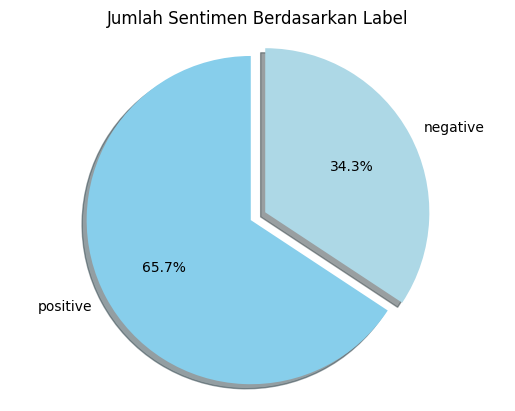

In [6]:
expl = (0.1, 0)
labels = ['positive', 'negative']
quantity = df['sentimen'].value_counts()
colors = ['skyblue', 'lightblue']

plt.title('Jumlah Sentimen Berdasarkan Label')
plt.pie(quantity, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, explode=expl)

plt.axis('equal')
plt.show()

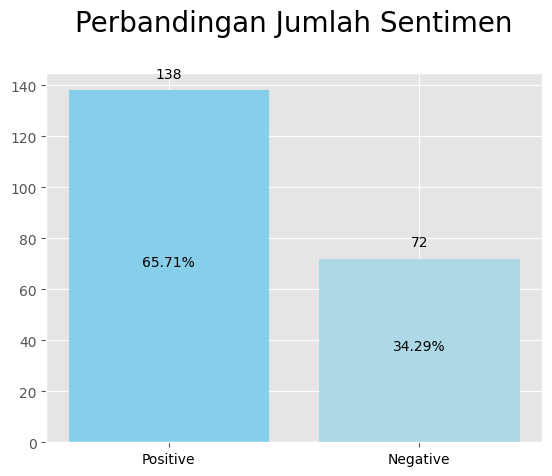

In [7]:
import matplotlib.pyplot as plt

# Set the labels for the bar chart
labels = ["Positive", "Negative"]

# Calculate the value counts of 'sentimen' column in the DataFrame
vals = df['sentimen'].value_counts()

# Create a range of x positions based on the number of unique values
xpos = range(len(vals))

# Calculate the total count of sentiment categories
total_count = sum(vals)

# Calculate the percentage values for each sentiment category
percentages = [(val / total_count) * 100 for val in vals]

# Set the style for the bar chart
with plt.style.context('ggplot'):
    # Plot the bar chart
    plt.bar(labels, vals, color=['skyblue', 'lightblue'])
    
    # Display the bar values on top of the bars
    for i, val in enumerate(vals):
        plt.text(i, val + 5, f'{val}', ha='center', color='black')
        
        # Display the percentage values above each bar
        plt.text(i, val/2, f'{percentages[i]:.2f}%', ha='center', color='black')
        
    # Set the ticks and labels for the x-axis
    plt.xticks(xpos, labels, color='black')
    
    # Set the title of the plot
    plt.title('Perbandingan Jumlah Sentimen', loc='center', pad=30, fontsize=20, color='black')

# Display the plot
plt.show()


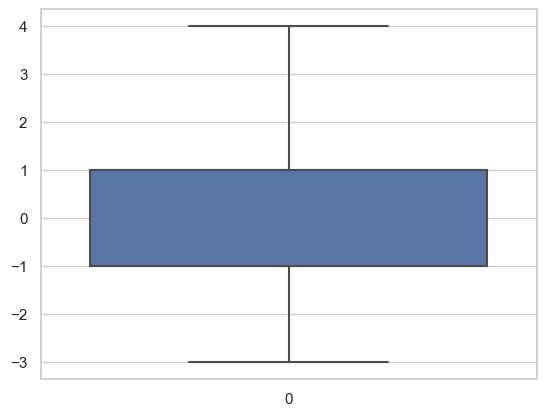

In [10]:
sns.set(style="whitegrid")
sns.boxplot(df['score']);

**VISUALISASI WORDCLOUD**

**POSITIF**

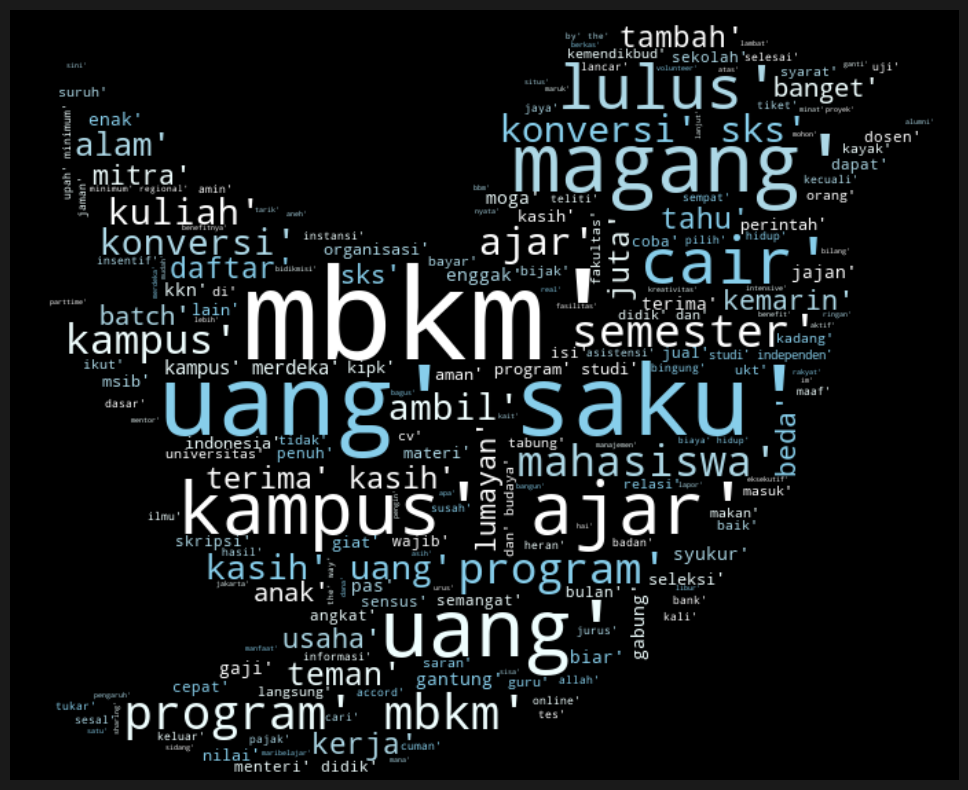

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
from itertools import cycle

# Membaca file csv
positif = pd.read_csv('C:/Users/dions/Music/data coding/mbkm1 positif.csv', sep=';')

# Menggabungkan semua kata dalam kolom 'text'
allWords = ' '.join([twts for twts in positif['text']])

# Membaca gambar mask
mask = np.array(Image.open('C:/Users/dions/Music/data coding/mask.png'))

# Membuat word cloud dengan mask dan mengubah warna tulisan menjadi Reds
wordCloud = WordCloud(background_color='black', mask=mask, colormap='Reds').generate(allWords)

# Menggunakan variasi warna tulisan dari daftar warna yang ditentukan
colors = cycle(['white', 'skyblue','Lightblue','azure'])
def color_func(word, font_size, position, orientation, random_state=30, **kwargs):
    return next(colors)

wordCloud.recolor(color_func=color_func)

# Menampilkan word cloud
plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**NEGATIF**

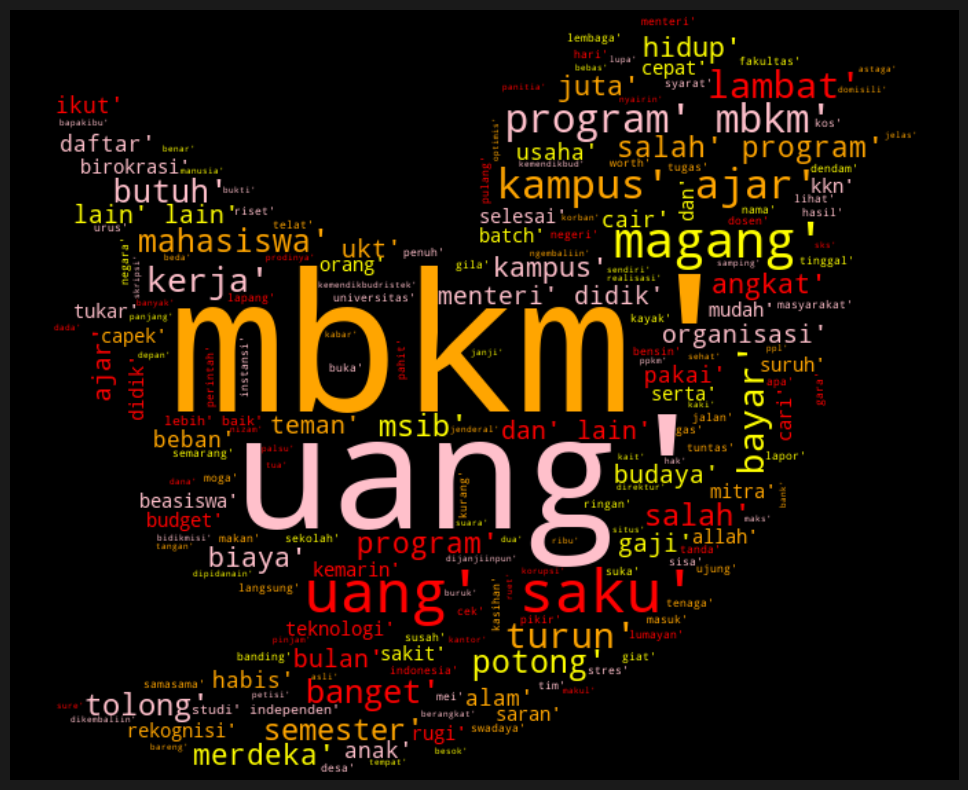

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
from itertools import cycle

# Membaca file csv
positif = pd.read_csv('C:/Users/dions/Music/data coding/mbkm1 negatif.csv', sep=';')

# Menggabungkan semua kata dalam kolom 'text'
allWords = ' '.join([twts for twts in positif['text']])

# Membaca gambar mask
mask = np.array(Image.open('C:/Users/dions/Music/data coding/mask.png'))

# Membuat word cloud dengan mask dan mengubah warna tulisan menjadi Reds
wordCloud = WordCloud(background_color='black', mask=mask, colormap='Reds').generate(allWords)

# Menggunakan variasi warna tulisan dari daftar warna yang ditentukan
colors = cycle(['orange', 'pink', 'red', 'yellow'])
def color_func(word, font_size, position, orientation, random_state=30, **kwargs):
    return next(colors)

wordCloud.recolor(color_func=color_func)

# Menampilkan word cloud
plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()


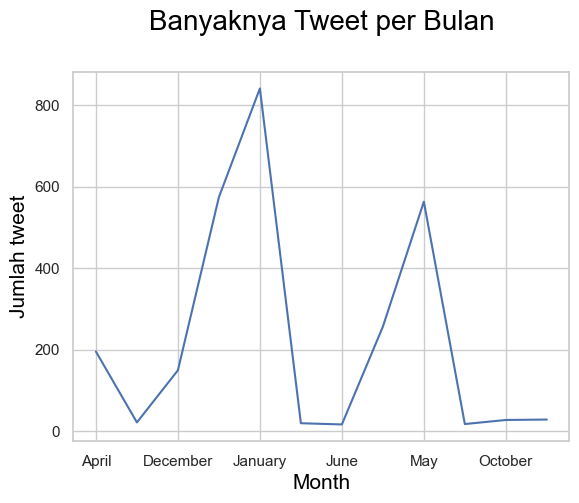

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

awal = pd.read_csv('C:/Users/dions/Music/data coding/mbkm1 tanggal1.csv', sep=';')
tanggal = pd.to_datetime(awal['Tanggal'])
awal['Month'] = tanggal.dt.month  # Menambahkan kolom Month dengan angka bulan

# Mengganti angka bulan menjadi nama bulan
awal['Month'] = awal['Month'].apply(lambda x: calendar.month_name[x])

# Menghitung jumlah tweet berdasarkan bulan
jumlah_tweet_per_bulan = awal.groupby(awal['Month'])['Month'].count()

plt.title('Banyaknya Tweet per Bulan', loc='center', pad=30, fontsize=20, color='black')
plt.xlabel('Bulan', fontsize=15, color='black')
plt.ylabel('Jumlah tweet', fontsize=15, color='black')
plt.grid(True)

jumlah_tweet_per_bulan.plot.line()

plt.show()
